In [207]:
from temgymbasic.model import (
    Model,
)
from temgymbasic import components as comp
from temgymbasic.utils import calculate_wavelength, calculate_phi_0
import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget

In [208]:
n_rays = 1000

phi_0 = 200e3
wavelength = calculate_wavelength(phi_0)
k = 2 * np.pi / wavelength
wavelengths = np.full(n_rays, wavelength)

size = 256
det_shape = (size, size)
pixel_size = 1e-7
dsize = det_shape[0] * pixel_size

x_det = np.linspace(-dsize / 2, dsize / 2, size)

sample_dist = 0.5
condenser_dist = 0.1    
objective_dist = sample_dist + 1e-2
total_dist = 1

sample_x_width = 0.1
sample_y_width = 0.1
sample_centre_yx = (0.1/2, 0)
sample_thickness = 50e-9

convergence_angle = 3e-3  #  milirads
beam_radius = condenser_dist * np.tan(convergence_angle)
print(beam_radius)

defocus = 1e-4

0.00030000090000324004


In [ ]:

components = (
    comp.GaussBeam(
        z=0.0,
        voltage=200e3,
        radius=beam_radius,
        wo=1e-10,
        amplitude=1.0,
    ),
    comp.Lens(
        z=condenser_dist,
        m=-1e-11,
        f=sample_dist - condenser_dist - defocus,
        name='Condenser Lens',
    ),
    comp.AttenuatingSample(
        z=sample_dist,
        x_width=sample_x_width,
        y_width=sample_y_width,
        thickness=50e-9,
        attenuation_coefficient=1e9,
        centre_yx=sample_centre_yx,
    ),
    comp.Lens(
        z=objective_dist,
        z1=sample_dist - objective_dist,
        z2=total_dist - objective_dist,
        name='Objective Lens',
    ),
    comp.AccumulatingDetector(
        z=total_dist,
        pixel_size=pixel_size,
        shape=det_shape,
        buffer_length=1,
        interference='gauss'
    ),
)


model = Model(components, backend='gpu')

sample_detector_model = comp.Detector(z=1.0,
                                      pixel_size=1e-10, 
                                      shape=(128, 128),
                                      interference='gauss')


rays_before_sample = model.run_to_z(z=sample_dist, num_rays=n_rays)
rays_after_sample = model.run_to_z(z=sample_dist+sample_thickness*2, num_rays=n_rays)

print(np.average(rays_before_sample.amplitude))
print(np.average(rays_after_sample.amplitude))

all_rays = tuple(model.run_iter(num_rays=1000, random=False))
rays_at_start = all_rays[0]
rays_at_end = all_rays[-1]


image_before_sample = sample_detector_model.get_image(rays_before_sample)
image_after_sample = sample_detector_model.get_image(rays_after_sample)
image_at_end = model.detector.get_image(rays_at_end)


1.0
0.4007999995344075


[0.         0.1        0.50000005 0.51       1.        ]


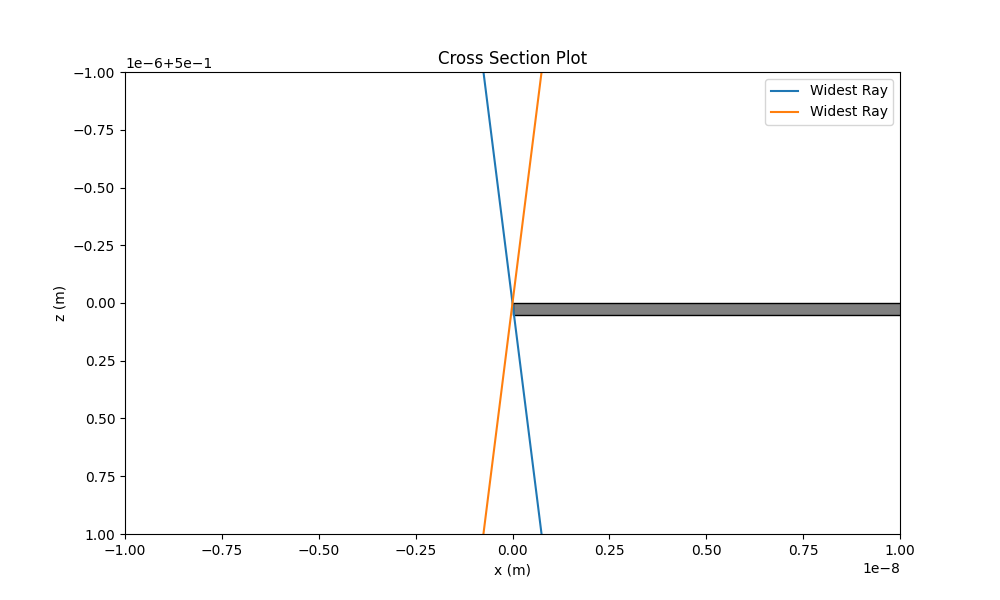

In [210]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the attenuating sample as a filled rectangle
sample_y = sample_centre_yx[0] + np.array([-0.05, 0.05, 0.05, -0.05, -0.05])
sample_z = [sample_dist, sample_dist, sample_dist + 50e-9, sample_dist + 50e-9, sample_dist]
ax.fill(sample_y, sample_z, 'gray', edgecolor='black')

xvals = np.stack(tuple(r.x_central.get() for r in all_rays), axis=0)
zvals = np.asarray(tuple(r.z for r in all_rays))

widest_ray_xvals = xvals[:, [np.argmin(xvals), np.argmax(xvals)]]

print(zvals)

ax.plot(widest_ray_xvals, zvals, label='Widest Ray')

ax.set_xlim(-1e-8, 1e-8)
ax.set_ylim(0.5 - 1000e-9, 0.5 + 1000e-9)
ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
ax.set_title('Cross Section Plot')
ax.legend()
# Plot the convergence angle as an arc
ax.invert_yaxis()

plt.show()

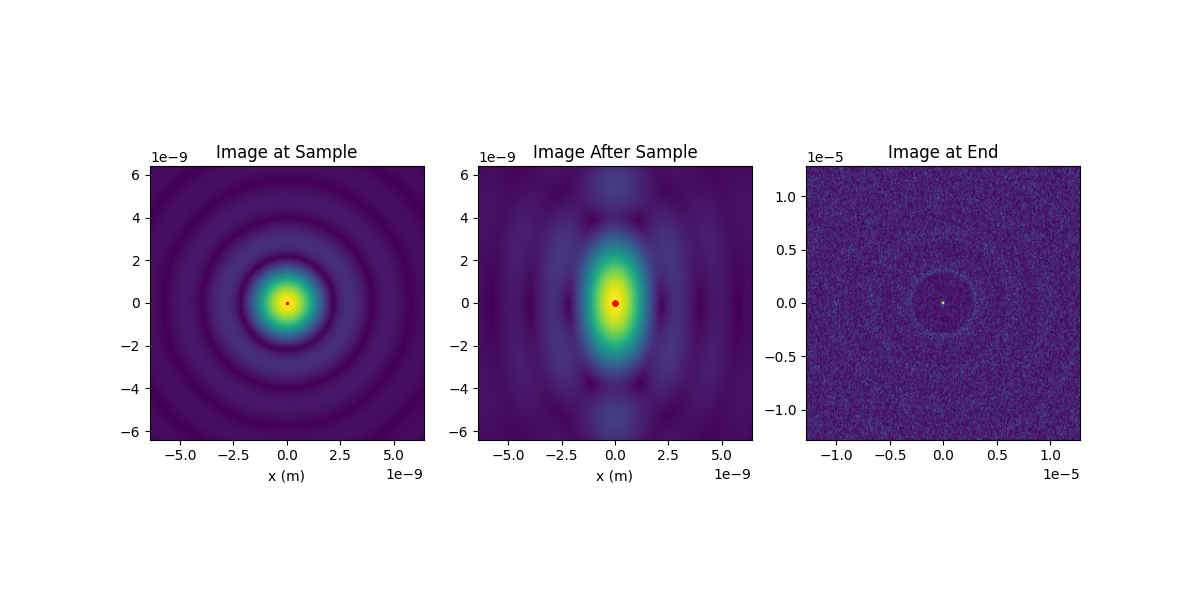

In [211]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].imshow(np.abs(image_before_sample), extent=sample_detector_model.extent)
axs[0].plot(rays_before_sample.x_central.get(), rays_before_sample.y_central.get(), 'r.', markersize=1)
axs[0].set_xlabel('x (m)')
axs[0].set_title('Image at Sample')

axs[1].imshow(np.abs(image_after_sample), extent=sample_detector_model.extent)
axs[1].plot(rays_after_sample.x_central.get(), rays_after_sample.y_central.get(), 'r.', markersize=1)
axs[1].set_xlabel('x (m)')
axs[1].set_title('Image After Sample')

axs[2].imshow(np.abs(image_at_end), extent=model.detector.extent)
axs[2].set_title('Image at End')

plt.show()